In [1]:
import jax.numpy as jnp
from fbpinns.problems import Problem

In [2]:
import jax.numpy as jnp
from fbpinns.problems import Problem

class HarmonicOscillator1D(Problem):
    """Solves the time-dependent damped harmonic oscillator using hard boundary conditions
          d^2 u      du
        m ----- + mu -- + ku = 0
          dt^2       dt

        Boundary conditions:
        u (0) = 1
        u'(0) = 0
    """

    @staticmethod
    def init_params(d=2, w0=20, sd=0.1):

        mu, k = 2*d, w0**2

        static_params = {
            "dims":(1,1),
            "d":d,
            "w0":w0,
            "mu":mu,
            "k":k,
            "sd":sd,
            }

        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,()),
            (0,(0,)),
            (0,(0,0))
        )
        return [[x_batch_phys, required_ujs_phys],]

    @staticmethod
    def constraining_fn(all_params, x_batch, u):

        sd = all_params["static"]["problem"]["sd"]
        x, tanh = x_batch[:,0:1], jnp.tanh

        u = 1 + (tanh(x/sd)**2) * u# applies hard BCs
        return u

    @staticmethod
    def loss_fn(all_params, constraints):

        mu, k = all_params["static"]["problem"]["mu"], all_params["static"]["problem"]["k"]

        _, u, ut, utt = constraints[0]
        phys = utt + mu*ut + k*u
        mse = jnp.mean((phys)**2)

        # Problem.attention_print(all_params, mse, 0, phys)

        return mse, phys

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):

        d, w0 = all_params["static"]["problem"]["d"], all_params["static"]["problem"]["w0"]

        w = jnp.sqrt(w0**2-d**2)
        phi = jnp.arctan(-d/w)
        A = 1/(2*jnp.cos(phi))
        cos = jnp.cos(phi + w * x_batch)
        exp = jnp.exp(-d * x_batch)
        u = exp * 2 * A * cos

        return u

In [3]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN, StackedChebyshevKAN, SplineKAN
from fbpinns.constants import Constants
from fbpinns.trainers import FBPINNTrainer, PINNTrainer


c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs=dict(
        xmin=np.array([0,]),
        xmax=np.array([1,]),
    ),
    problem=HarmonicOscillator1D,
    problem_init_kwargs=dict(
        d=4, w0=80,
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=[np.linspace(0,1,15)],
        subdomain_ws=[0.15*np.ones((15,))],
        unnorm=(0.,1.),
    ),
    # network=FCN,
    # network_init_kwargs=dict(
    #     layer_sizes=[1,8,1],
    # ),
    # network=StackedChebyshevKAN,
    # network_init_kwargs=dict(
    #     input_dim=1,
    #     hidden_dim=2,
    #     output_dim=1,
    #     degree=4
    # ),
    network=SplineKAN,
    network_init_kwargs=dict(
        in_dim=1,
        out_dim=1,
    ),
    optimiser_kwargs = dict(
        learning_rate=0.001
    ),
    ns=((1000,),),
    n_test=(1000,),
    n_steps=40000,
    # clear_output=True,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.99,
        out_dim=1,
        N=1000
    ),
    save_figures=True,
)

run = FBPINNTrainer(c)
# run = PINNTrainer(c)
all_params, metrics = run.train()

[INFO] 2025-05-28 19:34:09 - <fbpinns.constants.Constants object at 0x79f72fbe64b0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0]), 'xmax': array([1])}
problem: <class '__main__.HarmonicOscillator1D'>
problem_init_kwargs: {'d': 4, 'w0': 80}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])], 'subdomain_ws': [array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.SplineKAN'>
network_init_kwargs: {'in_dim': 1, 'out_dim': 1}
n_steps: 40000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((1000,),)
n_test: (1000,)
sampler: 

TypeError: mul got incompatible shapes for broadcasting: (1, 1, 9), (1, 1, 10).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
mse = metrics['mse']

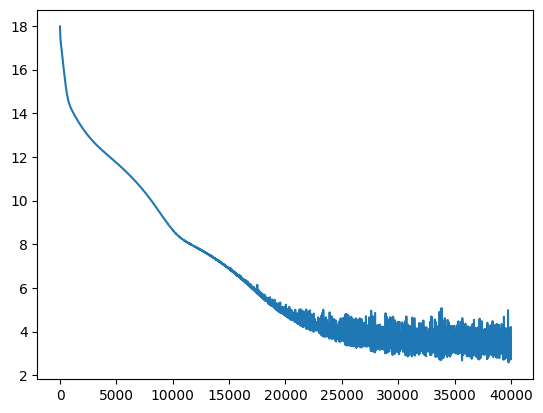

In [ ]:
plt.plot(np.arange(len(mse)), np.log(np.array(mse)))

In [ ]:
np.savez("mse.npz", mse=mse)

In [ ]:
metrics

{'mse': [63916992.0,
  62490640.0,
  61109420.0,
  59773560.0,
  58483480.0,
  57239268.0,
  56040796.0,
  54887736.0,
  53779588.0,
  52715744.0,
  51695528.0,
  50718232.0,
  49783060.0,
  48889120.0,
  48035424.0,
  47220868.0,
  46444268.0,
  45704360.0,
  44999836.0,
  44329332.0,
  43691452.0,
  43084792.0,
  42507936.0,
  41959476.0,
  41438008.0,
  40942160.0,
  40470572.0,
  40021944.0,
  39594984.0,
  39188452.0,
  38801140.0,
  38431892.0,
  38079572.0,
  37743104.0,
  37421452.0,
  37113636.0,
  36818708.0,
  36535796.0,
  36264064.0,
  36002720.0,
  35751020.0,
  35508284.0,
  35273840.0,
  35047072.0,
  34827408.0,
  34614296.0,
  34407216.0,
  34205700.0,
  34009296.0,
  33817596.0,
  33630208.0,
  33446778.0,
  33266990.0,
  33090550.0,
  32917192.0,
  32746682.0,
  32578804.0,
  32413366.0,
  32250206.0,
  32089166.0,
  31930112.0,
  31772926.0,
  31617498.0,
  31463736.0,
  31311554.0,
  31160872.0,
  31011620.0,
  30863734.0,
  30717156.0,
  30571832.0,
  30427714.0,